In [12]:
cd /content/drive/My Drive/DL/CS 189/hw5

/content/drive/My Drive/DL/CS 189/hw5


# Decision Tree Spam

In [0]:
import numpy as np
np.random.seed(1)

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from decision_tree import *
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
spam_path = "spam_data.mat"
data = scipy.io.loadmat(spam_path)
x = data["training_data"]
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=0.1)
pca_fit = pca.fit(x)
x = pca_fit.transform(x)
y = np.squeeze(data["training_labels"])
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
x_test = pca_fit.transform(data["test_data"])
x.shape,y.shape,x_test.shape

((5172, 2), (5172,), (5857, 2))

In [0]:
dt = DecisionTree(max_depth=5,header="spam_decisiontree")
dt.fit(x_train, y_train)

In [16]:
train_preds = dt.predict(x_train,"train")
print("training accuracy:",np.mean(train_preds==y_train))
val_preds = dt.predict(x_val,"val")
print("validation accuracy:",np.mean(val_preds==y_val))
dt.predict(x_test,"test")

training accuracy: 0.7585206671501088
validation accuracy: 0.7468599033816425
saved predictions


In [17]:
dt.print_tree()

Depth 0: feature #1>-0.2293331199559817

Depth 1: feature #1>0.22772147837751855
Depth 1: feature #1>-1.2209653472621824

Depth 2: feature #0>0.893548880069294
Depth 2: feature #0>-0.6846191143767626
Depth 2: feature #1>-0.23784178579362106
Depth 2: 1

Depth 3: 0
Depth 3: feature #0>-0.5013865029618801
Depth 3: feature #0>-0.6785687212680702
Depth 3: feature #0>-0.8141318123004576
Depth 3: 1
Depth 3: feature #1>-0.3070827504660713

Depth 4: feature #1>0.7621405990657201
Depth 4: 0
Depth 4: feature #0>-0.4237443658929741
Depth 4: 1
Depth 4: feature #1>-0.21565754609792698
Depth 4: feature #0>-0.827067784823384
Depth 4: 0
Depth 4: feature #0>0.6492707128967777

Depth 5: 0
Depth 5: 0
Depth 5: 0
Depth 5: 0
Depth 5: 0
Depth 5: 1
Depth 5: 0
Depth 5: 0
Depth 5: 1
Depth 5: 0



In [18]:
val_accs = []
for i in range(40):
  dt = DecisionTree(max_depth=i,header="spam_decisiontree")
  dt.fit(x_train, y_train)
  val_preds = dt.predict(x_val,"val")
  val_accs.append(np.mean(val_preds==y_val))
  if i % 5 == 0:
    print("finished predicting with depth",i)

finished predicting with depth 0
finished predicting with depth 5
finished predicting with depth 10
finished predicting with depth 15
finished predicting with depth 20
finished predicting with depth 25
finished predicting with depth 30
finished predicting with depth 35


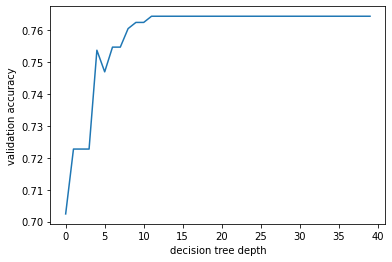

In [19]:
plt.xlabel("decision tree depth")
plt.ylabel('validation accuracy')
plt.plot([i for i in range(len(val_accs))], val_accs);

# Decision Tree Titanic

In [0]:
import numpy as np
np.random.seed(1)

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from decision_tree import *
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [0]:
train = pd.read_csv("titanic_training.csv")
test = pd.read_csv("titanic_testing_data.csv")

In [0]:
train.fillna(train.mean(),inplace=True)
test.fillna(train.mean(),inplace=True)

mode_sex = list(train["sex"])
mode_ticket = list(train["ticket"])
mode_embarked = list(train["embarked"])
reps = {"sex":max(set(mode_sex),key=mode_sex.count),
      "ticket":max(set(mode_ticket),key=mode_ticket.count),
      "embarked":max(set(mode_embarked),key=mode_embarked.count)}

train.fillna(reps,inplace=True)
test.fillna(reps,inplace=True)

One hot cabin

In [0]:
# training set
cabin = train[["cabin"]].copy()
cabin["cabin"] = cabin["cabin"].str.slice(0,1)
mode_cabin = list(cabin["cabin"])
cabin["cabin"] = cabin["cabin"].fillna(
                max(set(mode_cabin),
                key=mode_cabin.count))
one_hot = pd.get_dummies(cabin["cabin"])
train = pd.concat([train, cabin], axis=1, sort=False)
train = train.loc[:,~train.columns.duplicated()]

# test set
cabin = test[["cabin"]].copy()
cabin["cabin"] = cabin["cabin"].str.slice(0,1)
mode_cabin = list(cabin["cabin"])
cabin["cabin"] = cabin["cabin"].fillna(
                max(set(mode_cabin),
                key=mode_cabin.count))
one_hot = pd.get_dummies(cabin["cabin"])
test = pd.concat([test, cabin], axis=1, sort=False)
test = test.loc[:,~train.columns.duplicated()]

One hot sex

In [0]:
# training set
train = pd.concat([train, pd.get_dummies(train["sex"], prefix="sex")],axis=1)
train.drop(["sex"], axis=1,inplace=True)

# test set
test = pd.concat([test, pd.get_dummies(test["sex"], prefix="sex")],axis=1)
test.drop(["sex"], axis=1, inplace=True)

One hot embarked

In [0]:
# training set
train = pd.concat([train, pd.get_dummies(train["embarked"], prefix="embarked")],axis=1)
train.drop(["embarked"], axis=1, inplace=True)

# test set
test = pd.concat([test, pd.get_dummies(test["embarked"], prefix="embarked")],axis=1)
test.drop(["embarked"], axis=1, inplace=True)

In [0]:
def getnum(s):
    s = re.findall(r"\d+",str(s))
    return int(s[0]) if len(s)>=1 else -1

train["ticket"] = train["ticket"].apply(lambda s: getnum(s))
test["ticket"] = test["ticket"].apply(lambda s: getnum(s))
train["ticket"] = train["ticket"].apply(lambda s: train["ticket"].mean() if s==-1 else s)
test["ticket"] = test["ticket"].apply(lambda s: test["ticket"].mean() if s==-1 else s)

train_y = train["survived"]
train.drop(["survived"], axis=1, inplace=True)

train.drop(columns=["cabin"],axis=1,inplace=True)
test.drop(columns=["cabin"],axis=1,inplace=True)

In [27]:
train = train.values
x_test = test.values
x_train, x_val, y_train, y_val = \
train_test_split(train, train_y, test_size=0.2)
x_train.shape,test.shape

((800, 11), (310, 11))

In [0]:
dt = DecisionTree(header="titanic_decisiontree")
dt.fit(x_train, y_train)

In [29]:
train_preds = dt.predict(x_train,"train")
print("training accuracy:",np.mean(train_preds==y_train))
val_preds = dt.predict(x_val,"val")
print("validation accuracy:",np.mean(val_preds==y_val))
dt.predict(x_test,"test")

training accuracy: 0.62875
validation accuracy: 0.55
saved predictions


# Random Forest Spam

In [0]:
import numpy as np
np.random.seed(1)

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from decision_tree import *

import warnings
warnings.filterwarnings("ignore")

import sys
sys.setrecursionlimit(4000)

In [31]:
spam_path = "spam_data.mat"
data = scipy.io.loadmat(spam_path)
x = data["training_data"]
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=0.50, whiten=True)
pca_fit = pca.fit(x)
x = pca_fit.transform(x)

y = np.squeeze(data["training_labels"])
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
x_test = pca_fit.transform(data["test_data"])
print(x.shape,y.shape,x_test.shape)

(5172, 10) (5172,) (5857, 10)


In [0]:
rf = RandomForest(num_trees=25,header="spam_randomforest")
rf.fit(x_train, y_train)

In [33]:
train_preds = rf.predict(x_train,"train")
print("training accuracy:",np.mean(train_preds==y_train))
val_preds = rf.predict(x_val,"val")
print("validation accuracy:",np.mean(val_preds==y_val))
rf.predict(x_test,"test")

training accuracy: 0.7118685037466763
validation accuracy: 0.702415458937198
saved predictions


# Random Forest Titanic

In [0]:
import numpy as np
np.random.seed(10)

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from decision_tree import *

import warnings
warnings.filterwarnings("ignore")

In [0]:
train = pd.read_csv("titanic_training.csv")
test = pd.read_csv("titanic_testing_data.csv")

In [0]:
train.fillna(train.mean(),inplace=True)
test.fillna(train.mean(),inplace=True)

mode_sex = list(train["sex"])
mode_ticket = list(train["ticket"])
mode_embarked = list(train["embarked"])
reps = {"sex":max(set(mode_sex),key=mode_sex.count),
        "ticket":max(set(mode_ticket),key=mode_ticket.count),
        "embarked":max(set(mode_embarked),key=mode_embarked.count)}

train.fillna(reps,inplace=True)
test.fillna(reps,inplace=True)

One hot cabin

In [0]:
#one hot cabin training set
cabin = train[["cabin"]].copy()
cabin["cabin"] = cabin["cabin"].str.slice(0,1)
mode_cabin = list(cabin["cabin"])
cabin["cabin"] = cabin["cabin"].fillna(
                max(set(mode_cabin),
                key=mode_cabin.count))
one_hot = pd.get_dummies(cabin["cabin"])
train = pd.concat([train, cabin], axis=1, sort=False)
train = train.loc[:,~train.columns.duplicated()]

#one hot cabin test set
cabin = test[["cabin"]].copy()
cabin["cabin"] = cabin["cabin"].str.slice(0,1)
mode_cabin = list(cabin["cabin"])
cabin["cabin"] = cabin["cabin"].fillna(
                max(set(mode_cabin),
                key=mode_cabin.count))
one_hot = pd.get_dummies(cabin["cabin"])
# test.drop(columns=["cabin"],axis=1,inplace=True)
test = pd.concat([test, cabin], axis=1, sort=False)
test = test.loc[:,~train.columns.duplicated()]

One hot sex

In [0]:
#one hot sex training set
train = pd.concat([train, pd.get_dummies(train["sex"], prefix="sex")],axis=1)
train.drop(["sex"], axis=1,inplace=True)

#one hot sex test set
test = pd.concat([test, pd.get_dummies(test["sex"], prefix="sex")],axis=1)
test.drop(["sex"], axis=1, inplace=True)

One hot embarked

In [0]:
#one hot embarked training set
train = pd.concat([train, pd.get_dummies(train["embarked"], prefix="embarked")],axis=1)
train.drop(["embarked"], axis=1, inplace=True)

#one hot embarked test set
test = pd.concat([test, pd.get_dummies(test["embarked"], prefix="embarked")],axis=1)
test.drop(["embarked"], axis=1, inplace=True)

In [0]:
def getnum(s):
    s = re.findall(r"\d+",str(s))
    return int(s[0]) if len(s)>=1 else -1

train["ticket"] = train["ticket"].apply(lambda s: getnum(s))
test["ticket"] = test["ticket"].apply(lambda s: getnum(s))
train["ticket"] = train["ticket"].apply(lambda s: train["ticket"].mean() if s==-1 else s)
test["ticket"] = test["ticket"].apply(lambda s: test["ticket"].mean() if s==-1 else s)

train_y = train["survived"].values
train.drop(["survived"], axis=1, inplace=True)

train.drop(columns=["cabin"],axis=1,inplace=True)
test.drop(columns=["cabin"],axis=1,inplace=True)

In [41]:
train = train.values
x_test = test.values
x_train, x_val, y_train, y_val = \
train_test_split(train, train_y, test_size=0.2)
x_train.shape,test.shape

((800, 11), (310, 11))

In [0]:
rf = RandomForest(rand_features="log",num_trees=20,header="titanic_randomforest")
rf.fit(x_train, y_train)

In [43]:
train_preds = rf.predict(x_train,"train")
print("training accuracy:",np.mean(train_preds==y_train))
val_preds = rf.predict(x_val,"val")
print("validation accuracy:",np.mean(val_preds==y_val))
rf.predict(x_test,"test")

training accuracy: 0.62375
validation accuracy: 0.57
saved predictions
